# Triton Inference Server Simple Local Test

NVIDIA Triton client를 사용하여 서버가 수신 대기 중인 localhost:8000(http)이나 localhost:8001(grpc)으로 요청을 보냅니다.

<br>

## 1. Preparation
---

`requests.post(url, data)`로 요청을 보낼 수도 있지만, 결괏값을 파싱하는 게 번거롭기 때문에 triton에서 제공하는 client 라이브러리를 권장합니다. 

In [6]:
import json
import numpy as np
import requests
import tritonclient.http as httpclient
import tritonclient.grpc as grpcclient
from utils.inference_lib import encode_image, decode_image
    
def setup_triton_httpclient(url="localhost"):

    try:
        triton_client = httpclient.InferenceServerClient(
            url=f"{url}:8000",
            verbose=False,
        )
    except Exception as e:
        print("channel creation failed: " + str(e))
        sys.exit()

    return triton_client


def setup_triton_grpcclient(url="localhost"):

    try:
        triton_client = grpcclient.InferenceServerClient(
            url=f"{url}:8001",
        )
    except Exception as e:
        print("channel creation failed: " + str(e))
        sys.exit()

    return triton_client


def get_sample_binary_httpclient(payload):

    inputs = []
    outputs = []
    for idx, dic in enumerate(payload["inputs"]):
        input_name = dic["name"]
        input_value = dic["data"][0]

        input_value = np.array([input_value.encode('utf-8')], dtype=np.object_)

        input_value = np.expand_dims(input_value, axis=0)
        inputs.append(httpclient.InferInput(input_name, [1, 1], "BYTES"))
        inputs[idx].set_data_from_numpy(input_value)

    outputs.append(httpclient.InferRequestedOutput("generated_image", binary_data=True))

    return inputs, outputs


def get_sample_binary_grpcclient(payload):

    inputs = []
    outputs = []
    for idx, dic in enumerate(payload["inputs"]):
        input_name = dic["name"]
        input_value = dic["data"][0]

        input_value = np.array([input_value.encode('utf-8')], dtype=np.object_)

        input_value = np.expand_dims(input_value, axis=0)
        inputs.append(grpcclient.InferInput(input_name, [1, 1], "BYTES"))
        inputs[idx].set_data_from_numpy(input_value)

    outputs.append(grpcclient.InferRequestedOutput("generated_image"))

    return inputs, outputs


def triton_model_load(model_name, ip="localhost"):
    url = f'http://{ip}:8000/v2/repository/models/{model_name}/load'
    response = requests.post(url)
    return response


def triton_model_unload(model_name, ip="localhost"):
    url = f'http://{ip}:8000/v2/repository/models/{model_name}/unload'
    response = requests.post(url)
    return response


def infer_without_triton_client(model_name, model_version, payload, ip="localhost"):
    url = f'http://{ip}:8000/v2/models/{model_name}/versions/{model_version}/infer'
    response = requests.post(url, data=json.dumps(payload))
    return response.text

In [8]:
MODEL_DICT = {
    "BASE": "sd_base",
    "DEPTH": "sd_depth",
    "INPAINT": "sd_inpaint",
    "UPSCALE": "sd_upscale"
}
VERSION = 1

### Check Log

In [4]:
CONTAINER_ID=!docker container ls -q
FIRST_CONTAINER_ID = CONTAINER_ID[0]
!docker logs $FIRST_CONTAINER_ID


== Triton Inference Server ==

NVIDIA Release 23.05 (build <unknown>)
Triton Server Version 2.34.0

Copyright (c) 2018-2023, NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

Various files include modifications (c) NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

This container image and its contents are governed by the NVIDIA Deep Learning Container License.
By pulling and using the container, you accept the terms and conditions of this license:
https://developer.nvidia.com/ngc/nvidia-deep-learning-container-license

NOTE: CUDA Forward Compatibility mode ENABLED.
  Using CUDA 12.1 driver version 530.30.02 with kernel driver version 525.85.12.
  See https://docs.nvidia.com/deploy/cuda-compatibility/ for details.

I0815 15:29:08.187793 1 cache_manager.cc:478] Create CacheManager with cache_dir: '/opt/tritonserver/caches'
I0815 15:29:08.374832 1 pinned_memory_manager.cc:240] Pinned memory pool is created at '0x7f69f2000000' with size 268435456
I0815 15:29:08.376891 1 cuda_m

### Health check

모델 서빙이 가능한 상태인지 헬스 체크를 통해 확인합니다. 200 응답을 받아야 합니다.

In [5]:
!curl -v localhost:8000/v2/health/ready

*   Trying 127.0.0.1:8000...
* Connected to localhost (127.0.0.1) port 8000 (#0)
> GET /v2/health/ready HTTP/1.1
> Host: localhost:8000
> User-Agent: curl/8.0.1
> Accept: */*
> 
< HTTP/1.1 200 OK
< Content-Length: 0
< Content-Type: text/plain
< 
* Connection #0 to host localhost left intact


<br>

## 2. Stable Diffusion Base model 
---

### Health check

In [9]:
!curl -v localhost:8000/v2/models/{MODEL_DICT["BASE"]}/versions/{VERSION}/ready

*   Trying 127.0.0.1:8000...
* Connected to localhost (127.0.0.1) port 8000 (#0)
> GET /v2/models/sd_base/versions/1/ready HTTP/1.1
> Host: localhost:8000
> User-Agent: curl/8.0.1
> Accept: */*
> 
< HTTP/1.1 200 OK
< Content-Length: 0
< Content-Type: text/plain
< 
* Connection #0 to host localhost left intact


In [12]:
inputs = dict(
    prompt="Infinity pool on top of a high rise overlooking Central Park",
    negative_prompt="blur, signature, low detail, low quality",
    gen_args=json.dumps(dict(num_inference_steps=50, guidance_scale=8)),
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}

### Inference without triton client

In [13]:
response_text = infer_without_triton_client(MODEL_DICT["BASE"], 1, payload)

### httpclient inference

In [14]:
triton_client = setup_triton_httpclient()
inputs, outputs = get_sample_binary_httpclient(payload)

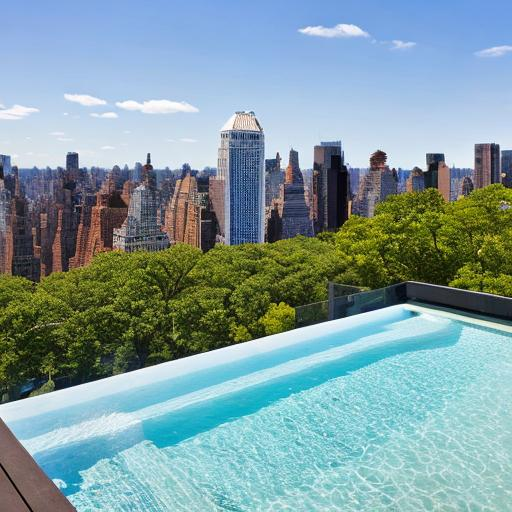

CPU times: user 43 ms, sys: 0 ns, total: 43 ms
Wall time: 3.92 s


In [15]:
%%time
results = triton_client.infer(
    MODEL_DICT["BASE"],
    inputs,
    outputs=outputs,
    headers=None
)

output_encoded = results.as_numpy('generated_image')
output_image = decode_image(output_encoded[0].decode('utf-8'))
display(output_image)

### grpcclient

In [16]:
triton_client = setup_triton_grpcclient()
inputs, outputs = get_sample_binary_grpcclient(payload)

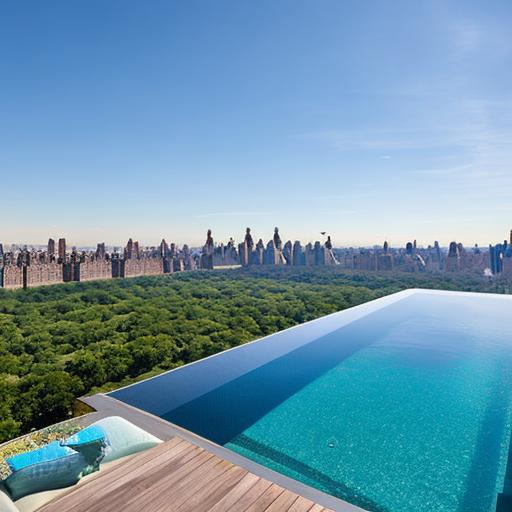

CPU times: user 29.5 ms, sys: 277 µs, total: 29.8 ms
Wall time: 3.92 s


In [17]:
%%time
results = triton_client.infer(
    MODEL_DICT["BASE"],
    inputs,
    outputs=outputs,
    headers=None
)

output_encoded = results.as_numpy('generated_image')
output_image = decode_image(output_encoded[0].decode('utf-8'))
display(output_image)

<br>

## 3. Stable Diffusion Depth model 
---

### Unload a model and load another model

In [18]:
%%time
triton_model_unload(MODEL_DICT["BASE"])
triton_model_load(MODEL_DICT["DEPTH"])

CPU times: user 7.42 ms, sys: 289 µs, total: 7.71 ms
Wall time: 30.4 s


<Response [200]>

In [19]:
triton_client = setup_triton_httpclient()

In [23]:
inputs = dict(
    prompt="highly detailed oil painting of an inifinity pool overlooking central park",
    image=input_image,
    gen_args=json.dumps(dict(num_inference_steps=50, strength=0.8)),
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}

### Inference without triton client

In [24]:
response_text = infer_without_triton_client(MODEL_DICT["DEPTH"], 1, payload)

### httpclient inference

In [25]:
original_image = output_image
input_image = encode_image(original_image).decode("utf-8")

inputs, outputs = get_sample_binary_httpclient(payload)

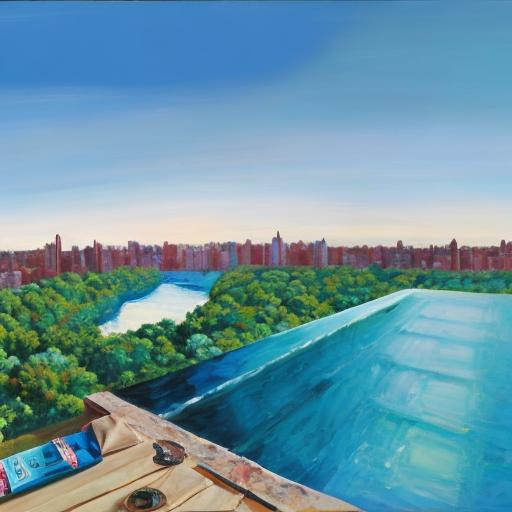

In [26]:
results = triton_client.infer(
    MODEL_DICT["DEPTH"],
    inputs,
    outputs=outputs,
    headers=None
)

output_encoded = results.as_numpy('generated_image')
output_image = decode_image(output_encoded[0].decode('utf-8'))
display(output_image)

<br>

## 4. Stable Diffusion Inpainting model 
---

### Unload a model and load another model

In [27]:
%%time
triton_model_unload(MODEL_DICT["DEPTH"])
triton_model_load(MODEL_DICT["INPAINT"])

CPU times: user 4.57 ms, sys: 0 ns, total: 4.57 ms
Wall time: 28.3 s


<Response [200]>

In [29]:
from PIL import Image
from io import BytesIO
source_image = Image.open("sample_images/bertrand-gabioud.png")

image = encode_image(source_image).decode("utf8")
mask_image = encode_image(Image.open("sample_images/bertrand-gabioud-mask.png")).decode("utf8")
inputs = dict(
    prompt="building, facade, paint, windows",
    image=image,
    mask_image=mask_image,
    negative_prompt="tree, obstruction, sky, clouds",
    gen_args=json.dumps(dict(num_inference_steps=50, guidance_scale=10)),
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}

### httpclient inference

In [30]:
inputs, outputs = get_sample_binary_httpclient(payload)

In [33]:
results = triton_client.infer(
    MODEL_DICT["INPAINT"],
    inputs,
    outputs=outputs,
    headers=None
)

output_encoded = results.as_numpy('generated_image')
filled_image = decode_image(output_encoded[0].decode('utf-8'))

source image


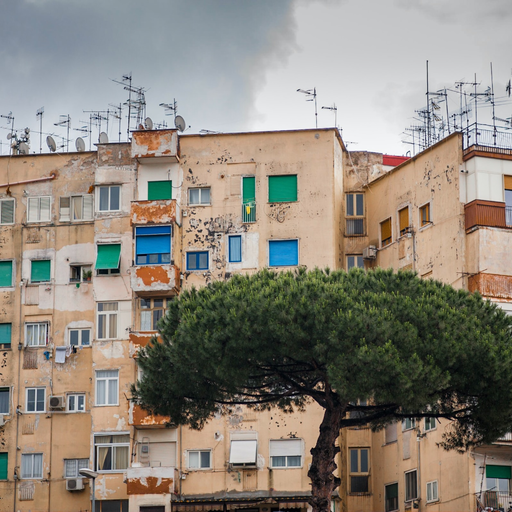

filled image


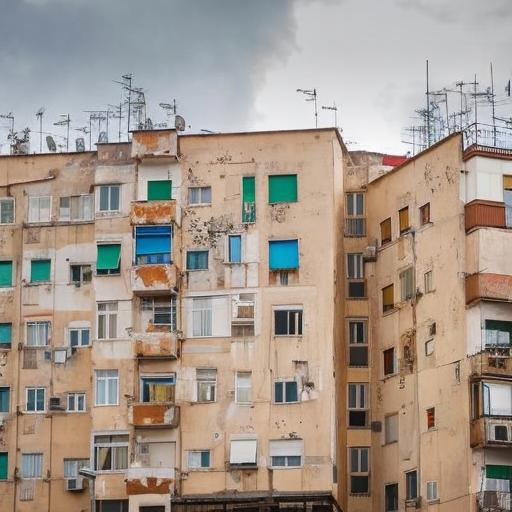

In [34]:
print("source image")
display(source_image)

print("filled image")
display(filled_image)